In [78]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
import random

%matplotlib inline

In [7]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(10,6))

In [9]:
shp_path = "Tracts_WUI_ByYear/tracts_wui_2010.shp"
sf = shp.Reader(shp_path)

In [13]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [1]:
df = read_shapefile(sf)
print(df.shape)
df.head()

NameError: name 'read_shapefile' is not defined

In [36]:
def plot_map(sf, x_lim = None, y_lim = None, figsize = (11,9)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

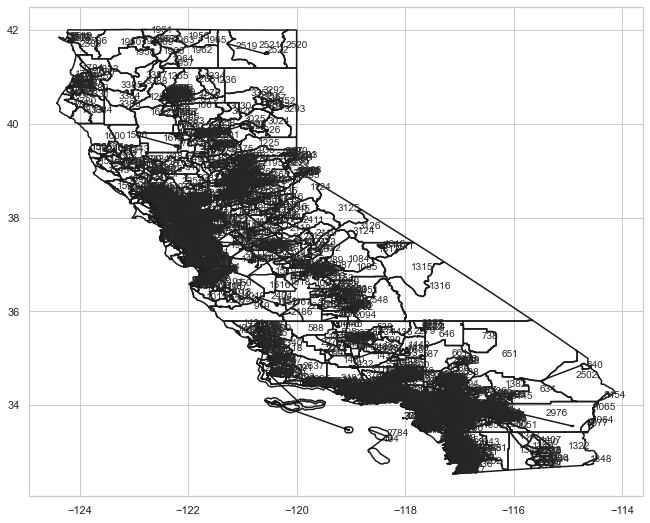

In [37]:
plot_map(sf)

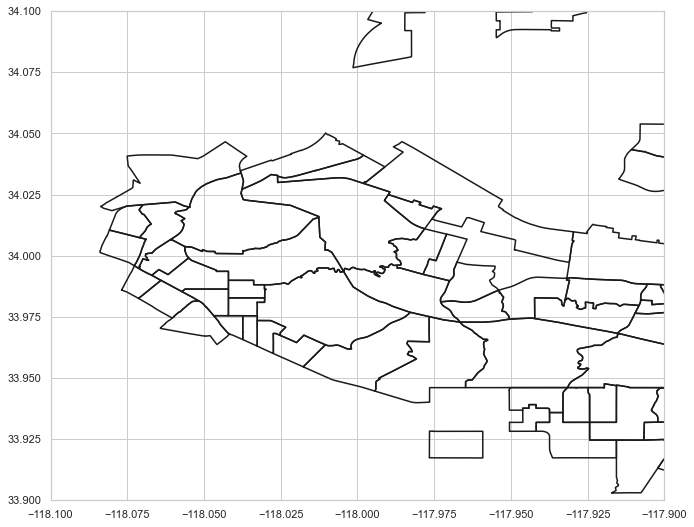

In [43]:
x_lim = (-118.1, -117.9) # latitude 
y_lim = (33.9, 34.1) # longitude
plot_map(sf, x_lim, y_lim)

In [40]:
def plot_map2(id, sf, x_lim = None, y_lim = None, figsize=(11,9)):
    '''
    Plot map with lim coordinates
    '''
   
    plt.figure(figsize = figsize)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
    shape_ex = sf.shape(id)
    x_lon = np.zeros((len(shape_ex.points),1))
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    plt.plot(x_lon,y_lat, 'r', linewidth=3) 
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

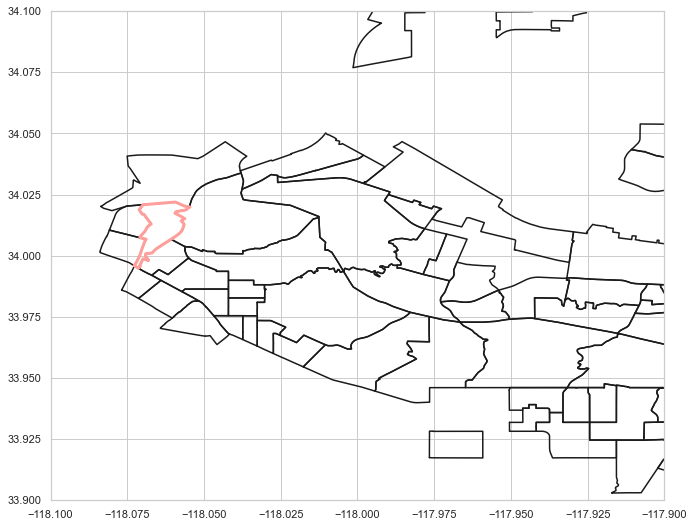

In [44]:
plot_map2(0, sf, x_lim, y_lim)

In [45]:
def plot_map_fill(id, sf, x_lim = None, 
                          y_lim = None, 
                          figsize = (11,9), 
                          color = 'r'):
    '''
    Plot map with lim coordinates
    '''
    
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
        
    shape_ex = sf.shape(id)
    x_lon = np.zeros((len(shape_ex.points),1))
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    ax.fill(x_lon,y_lat, color)
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

<Figure size 792x648 with 0 Axes>

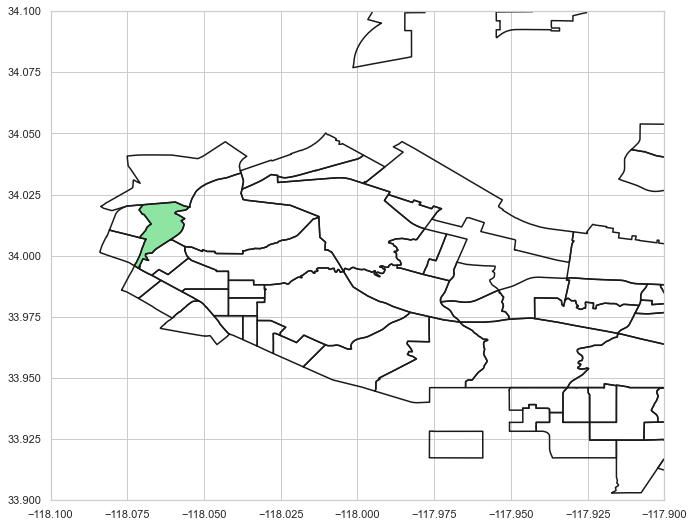

In [46]:
plot_map_fill(0, sf, x_lim, y_lim, color='g')

In [47]:
def plot_map_fill_multiples_ids(title, comuna, sf, 
                                               x_lim = None, 
                                               y_lim = None, 
                                               figsize = (11,9), 
                                               color = 'r'):
    '''
    Plot map with lim coordinates
    '''
    
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
            
    for id in comuna:
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        ax.fill(x_lon,y_lat, color)
             
        x0 = np.mean(x_lon)
        y0 = np.mean(y_lat)
        plt.text(x0, y0, id, fontsize=10)
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

<Figure size 792x648 with 0 Axes>

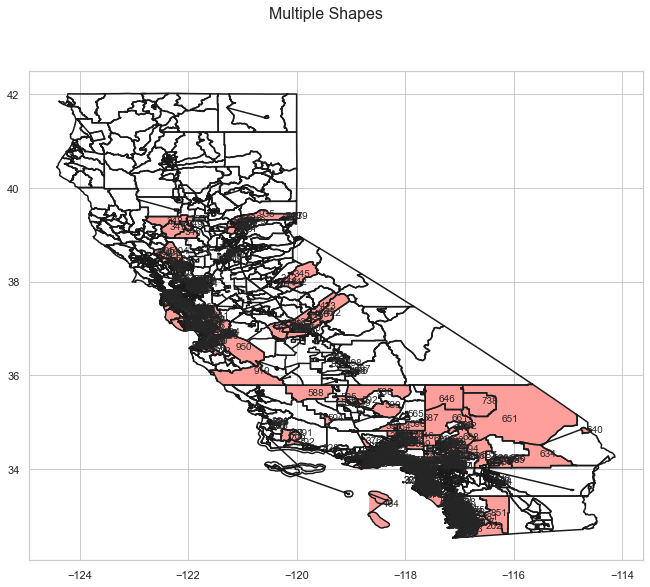

In [53]:
comuna_id = list(range(1000))
plot_map_fill_multiples_ids("Multiple Shapes", 
                            comuna_id, sf, color = 'r')

In [64]:
def plot_by_names(sf, title, names, color):
    '''
    Plot map with selected comunes, using specific color
    '''
    
    df = read_shapefile(sf)
    comuna_id = []
    for x in names:
        print(x)
        comuna_id.append(df[df.NAME10 == str(x)].index.values[0])
    plot_map_fill_multiples_ids(title, comuna_id, sf, 
                                       x_lim = None, 
                                       y_lim = None, 
                                       figsize = (11,9), 
                                       color = color)

In [65]:
names = ["5004.3", "451.03", "464.4", "451.08", "1221.22" ]
plot_by_names(sf, "Title", names, 'c')

5004.3


IndexError: index 0 is out of bounds for axis 0 with size 0

In [71]:
def calc_color(data, color=None):
        if color   == 1:
            color_sq = ['#dadaebFF','#bcbddcF0','#9e9ac8F0', '#807dbaF0','#6a51a3F0','#54278fF0']
            colors = 'Purples'
        elif color == 2:
            color_sq = ['#c7e9b4','#7fcdbb','#41b6c4',
                        '#1d91c0','#225ea8','#253494']
            colors = 'YlGnBu';
        elif color == 3:
            color_sq = ['#f7f7f7','#d9d9d9','#bdbdbd',
                        '#969696','#636363','#252525']; 
            colors = 'Greys';
        elif color == 9:
            color_sq = ['#ff0000','#ff0000','#ff0000',
                        '#ff0000','#ff0000','#ff0000']
        else:
            color_sq = ['#ffffd4','#fee391','#fec44f',
                        '#fe9929','#d95f0e','#993404']; 
            colors = 'YlOrBr';
        new_data, bins = pd.qcut(data, 6, retbins=True, 
        labels=list(range(6)))
        color_ton = []
        for val in new_data:
            color_ton.append(color_sq[val]) 
        if color != 9:
            colors = sns.color_palette(colors, n_colors=6)
            sns.palplot(colors, 0.6);
            for i in range(6):
                print ("\n"+str(i+1)+': '+str(int(bins[i]))+
                       " => "+str(int(bins[i+1])-1), end =" ")
            print("\n\n   1   2   3   4   5   6")    
        return color_ton, bins;

In [97]:
def plot_comunas_data(sf, title, comunas, data=None, 
                      color=None, print_id=False):
    '''
    Plot map with selected comunes, using specific color
    '''
    
    color_ton, bins = calc_color(data, color)
    df = read_shapefile(sf)
    comuna_id = []
    for i in comunas:
        i = i.upper()
        comuna_id.append(df[df.NAME10 == i.upper()].index.values[0])
    plot_map_fill_multiples_ids_tone(sf, title, comuna_id, 
                                     print_id, 
                                     color_ton, 
                                     bins, 
                                     x_lim = None, 
                                     y_lim = None, 
                                     figsize = (11,9));

In [98]:
def plot_map_fill_multiples_ids_tone(sf, title, comuna,  
                                     print_id, color_ton, 
                                     bins, 
                                     x_lim = None, 
                                     y_lim = None, 
                                     figsize = (11,9)):
    '''
    Plot map with lim coordinates
    '''
        
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')

        for id in comuna:
            shape_ex = sf.shape(id)
            x_lon = np.zeros((len(shape_ex.points),1))
            y_lat = np.zeros((len(shape_ex.points),1))
            for ip in range(len(shape_ex.points)):
                x_lon[ip] = shape_ex.points[ip][0]
                y_lat[ip] = shape_ex.points[ip][1]
            ax.fill(x_lon,y_lat, color_ton[comuna.index(id)])
            if print_id != False:
                x0 = np.mean(x_lon)
                y0 = np.mean(y_lat)
                plt.text(x0, y0, id, fontsize=10)
        if (x_lim != None) & (y_lim != None):     
            plt.xlim(x_lim)
            plt.ylim(y_lim)


1: 0 => 2822 
2: 2823 => 3647 
3: 3648 => 4489 
4: 4490 => 5308 
5: 5309 => 6463 
6: 6464 => 39247 

   1   2   3   4   5   6


KeyboardInterrupt: 

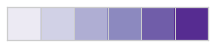

<Figure size 792x648 with 0 Axes>

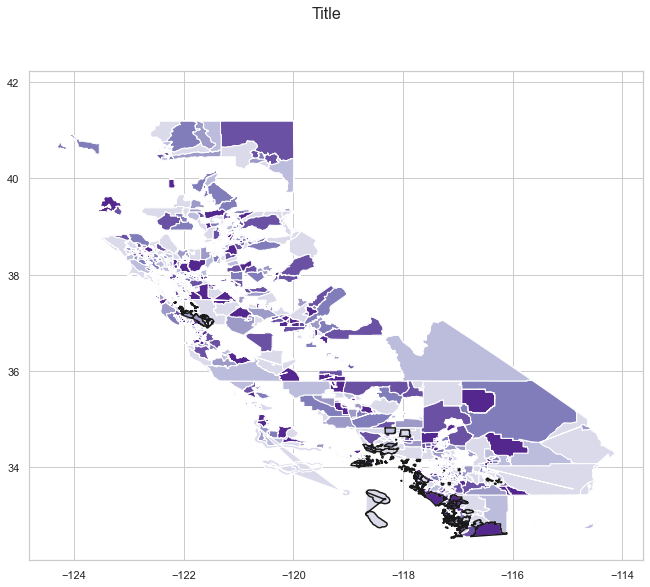

In [99]:
names = df.NAME10
data = df.estimate
print_id = False # The shape id will be printed
color_pallete = 1 # 'Purples'
plot_comunas_data(sf, 'Title', names, data, color_pallete, print_id)
# Infinite loop :(

In [ ]:
names = df.NAME10
data = df.estimate
print_id = False # The shape id will be printed
color_pallete = 1 # 'Purples'
plot_comunas_data(sf, 'Title', names, data, color_pallete, print_id, x_lim=x_lim, y_lim=y_lim)